In [ ]:
#|default_exp my_fff

In [ ]:
#|hide
import nbdev
import math
import torch.optim as optim
from torch import tensor
import torchvision.transforms as T
from torchvision.datasets import MNIST
from fastai.vision.all import *
from fastai.callback.wandb import *

import FastFF.fff as fff
from FastFF.activations import *
from FastFF.performance import *

In [ ]:
#|export
import torch
import torch.nn as nn, torch.nn.functional as F
from fastcore.all import *

In [ ]:
# TODO
class ParallelLinear(nn.Module):
    # should be like  nn.ModuleList(nn.Linear(hidden_dim, out_dim) for _ in range(self.n_leaves))
    # but compute in parallel
    pass

In [ ]:
#|export
class FFF(nn.Module):
    def __init__(self, in_dim, out_dim, depth, act=nn.ReLU, hidden_dim = None):
        super().__init__()
        store_attr()
        self.n_leaves = 2**depth
        self.nodes = nn.Linear(in_dim, self.n_leaves-1)
        self.leaves = nn.Linear(in_dim, ifnone(hidden_dim, out_dim)*self.n_leaves)
        if hidden_dim: self.leaves_out = nn.ModuleList(nn.Linear(hidden_dim, out_dim) for _ in range(self.n_leaves))
        self.act = act() if act else noop
 
    def forward(self, x): return self.train_forward(x) if self.training else self.eval_forward(x)

    def train_forward(self, x):
        bs = x.shape[0]
        probs = F.sigmoid(self.nodes(x))                                           # (bs, n_leaves-1)
        leaf_distr = torch.ones([bs,self.n_leaves], device=x.device)               # (bs, n_leaves)
        for d in range(self.depth):
            layer_probs = probs[:, 2**d-1 : 2**(d+1)-1]                            # (bs, 2**d)
            mask = torch.stack((1-layer_probs, layer_probs), dim=2).view(bs, -1)   # (bs, 2**(d+1) )
            leaf_distr = leaf_distr.view(bs, 2**(d+1), -1) * mask[..., None]       # (bs, 2**(d+1), n_leaves//2**(d+1) )

        # save distribution for visuals
        self.leaf_distr = leaf_distr.detach()
        
        logits = self.act(self.leaves(x)).view(bs,self.n_leaves, -1)               # (bs, n_leaves, out_dim/hidden_dim)
        if self.hidden_dim: logits =  self.act(torch.stack([self.leaves_out[i](logits[:,i,:]) for i in range(self.n_leaves)], dim=1)) # (bs, n_leaves, out_dim)
        return torch.bmm(logits.transpose(1,2), leaf_distr).squeeze(-1)
    
    def eval_forward(self, x):
        bs = x.shape[0]
        choices = self.nodes(x)>0 # (bs, n_leaves-1)
        leaf_distr = torch.zeros((bs,1), dtype=torch.long, device=x.device)
        for _ in range(self.depth):
            leaf_distr = 2 * leaf_distr + 1 + choices.gather(1,leaf_distr) # (bs, 1)
        
        leaf_distr = leaf_distr.squeeze(-1) - self.n_leaves + 1
        
        # save distribution for visuals
        self.leaf_distr = leaf_distr.detach()
        
        w, b = self.leaves.weight.view(self.n_leaves, -1, self.in_dim), self.leaves.bias.view(self.n_leaves, -1)
        w = torch.index_select(w, 0, leaf_distr.squeeze()) # (bs, in_dim, out_dim/hidden_dim)
        b = torch.index_select(b, 0, leaf_distr.squeeze()) # (bs, out_dim/hidden_dim)
        
        logits = self.act(torch.bmm(w, x[...,None]).squeeze(-1) + b) # (bs, out_dim/hidden_dim)
        if self.hidden_dim: logits =  self.act(torch.stack([self.leaves_out[b](logits[i]) for i,b in enumerate(leaf_distr)], dim=0))
        return logits

## Model performance comparison

In [ ]:
d,l = 3, 128

In [ ]:
x = to_device(torch.randn(2,28*28))

In [ ]:
model = FFF(28*28, 10, d, act=nn.GELU, hidden_dim=l).to(x.device).eval()
with torch.no_grad():
    %timeit -n 50 model(x);

The slowest run took 7.54 times longer than the fastest. This could mean that an intermediate result is being cached.
1.97 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [ ]:
model = fff.FFF(28*28, l, 10,  d, activation=nn.GELU()).to(x.device).eval()
with torch.no_grad():
    %timeit -n 50 model(x);

2.29 ms ± 552 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## Accuracy comparison

In [ ]:
d, l = 3, 64
bs = 512

In [ ]:
#|hide
mean, std = 0.130652368068695068, 0.307504087686538696

tfm = T.Compose([T.ToTensor(),T.Normalize((mean,), (std,)),
                 T.Lambda(lambda x: x.view(-1,28*28).squeeze())])

train_dataset = MNIST('../data', train=True, download=True,transform=tfm)
test_dataset = MNIST('../data', train=False, download=True,transform=tfm)
dls = DataLoaders(TfmdDL(train_dataset, bs, True),TfmdDL(test_dataset, bs, False))

In [ ]:
#|hide
#|eval: false
model = FFF(28*28, 10, d, act=nn.GELU, hidden_dim=l)
cbs = [FFFLeavesDistCB('leaf_distr'), GetGradCB(['nodes.weight'])]
learn = Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy, opt_func = Adam, cbs=cbs)

In [ ]:
#|eval: false
learn.fit_one_cycle(15, lr_max=2e-2);

epoch,train_loss,valid_loss,accuracy,time
0,0.287963,0.382564,0.896800,00:14
1,0.175504,0.466314,0.879900,00:10
2,0.202980,0.558680,0.870700,00:16
3,0.218245,0.276645,0.930400,00:15
4,0.193032,0.297262,0.935300,00:13
5,0.176273,0.228494,0.943500,00:11
6,0.154149,0.232073,0.948700,00:14
7,0.131050,0.189538,0.954000,00:12
8,0.109252,0.176318,0.961400,00:11
9,0.078243,0.167712,0.963400,00:13


In [ ]:
ax = subplots(figsize=(15,5))[1][0]
cbs[0].leaf_hist(-1, ax=ax)

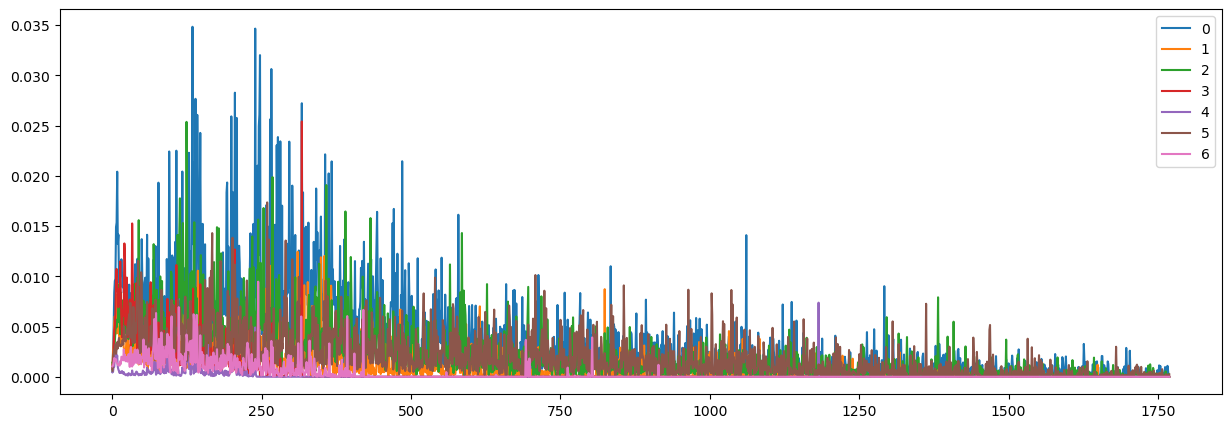

In [ ]:
ax = subplots(figsize=(15,5))[1][0]
cbs[1].show('nodes.weight', ax=ax)

In [ ]:

model2 = fff.FFF(28*28, l, 10,  d, activation=nn.GELU())
cbs = [FFFLeavesDistCB('leaves'), GetGradCB(['node_weights'])]
learn = Learner(dls, model2, loss_func=F.cross_entropy, metrics=accuracy, opt_func = Adam, cbs=cbs)

In [ ]:
#|eval: false
learn.fit_one_cycle(15, lr_max=2e-2);

epoch,train_loss,valid_loss,accuracy,time
0,0.267549,0.367962,0.895900,00:20
1,0.179609,0.514283,0.879400,00:18
2,0.221873,0.462007,0.895600,00:19
3,0.223778,0.323025,0.914100,00:14
4,0.197317,0.261853,0.940800,00:16
5,0.167751,0.254486,0.938600,00:18
6,0.152344,0.262399,0.939700,00:14
7,0.119000,0.220222,0.950700,00:13
8,0.100066,0.197574,0.956300,00:13
9,0.076608,0.196175,0.955100,00:12


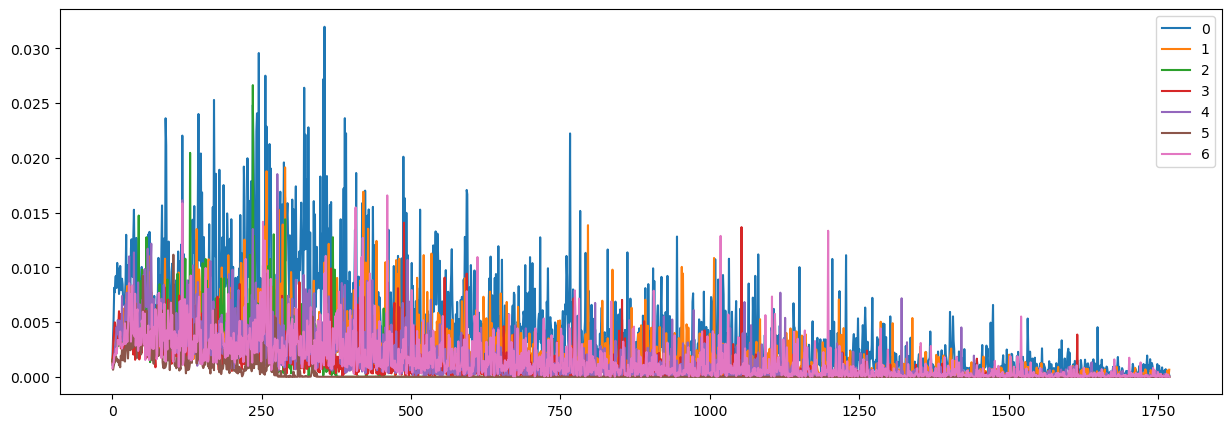

In [ ]:
ax = subplots(figsize=(15,5))[1][0]
cbs[1].show('node_weights', ax=ax)